In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import tab20, tab20c
import pandas as pd
import pyFAST.linearization.linearization as lin

In [2]:
prefix = 'NREL-1.7-103'
rotor_speed_step = 1.0 # [RPM]
BladeLen = 103./2 # [m]
TowerLen = 80. # [m]

In [3]:
# copied from `check_NREL-*-*.ipynb`
design_flap_freqs = [0.81347805, 2.80948782, 6.08713187, 9.57721303, 14.05396425]
design_edge_freqs = [1.42516924, 4.85471061, 11.28129568, 18.64405895, 28.26697674]
design_tower_fa_freqs = [0.27116056, 2.31620158, 4.72774086]
design_tower_ss_freqs = [0.2709746,  2.25529807, 4.58439115]

## postprocessing with `pyFAST`
to guess at modes

In [4]:
fstFiles = glob.glob('output/*.fst')
fstFiles.sort()
OP, Freq, Damp, UnMapped, ModeData, modeID_file = lin.postproCampbell(fstFiles, BladeLen, TowerLen)

run_pyMBC:
       Lin. files: output/000_0.0rpm.*.lin (1)
       Lin. files: output/001_1.0rpm.*.lin (36)
       Lin. files: output/002_2.0rpm.*.lin (36)
       Lin. files: output/003_3.0rpm.*.lin (36)
       Lin. files: output/004_4.0rpm.*.lin (36)
       Lin. files: output/005_5.0rpm.*.lin (36)
       Lin. files: output/006_6.0rpm.*.lin (36)
       Lin. files: output/007_7.0rpm.*.lin (36)
       Lin. files: output/008_8.0rpm.*.lin (36)
       Lin. files: output/009_9.0rpm.*.lin (36)
       Lin. files: output/010_10.0rpm.*.lin (36)
       Lin. files: output/011_11.0rpm.*.lin (36)
       Lin. files: output/012_12.0rpm.*.lin (36)
       Lin. files: output/013_13.0rpm.*.lin (36)
       Lin. files: output/014_14.0rpm.*.lin (36)
       Lin. files: output/015_15.0rpm.*.lin (36)
       Lin. files: output/016_16.0rpm.*.lin (36)


In [5]:
#fig, axes, figName =  lin.plotCampbellDataFile(modeID_file, 'ws', ylim=None)
fig, axes, figName =  lin.plotCampbellDataFile(modeID_file)
plt.close()

Reading csv file:  output/Campbell_OP.csv
Reading csv file:  output/Campbell_ModesID.csv


## read operating points table

In [6]:
op = pd.read_csv(f'../{prefix}_openfast.csv').set_index('rotor speed [RPM]')
op = op.loc[op['Wind1VelX_[m/s]'] <= 11]
GenTorque = op['GenTq_[kN-m]'] * 1000.
GenTorque.loc[0] = 1e-9
GenTorque.sort_index(inplace=True)
GenTorque.loc[16.0] = np.nan
GenTorque = GenTorque.fillna(method='ffill')

In [7]:
df = pd.read_csv('MBC_natural_frequencies.csv',header=None)
rotor_speeds = df.index.values * rotor_speed_step
rotor_speeds_Hz = rotor_speeds / 60.
df = df.set_index(rotor_speeds)
df = df[np.arange(0,len(df.columns),2)] # modes are duplicated b/c of complex conjugates
df.columns = np.arange(len(df.columns))

## final Campbell diagram

styles based on `tab20c`, grouping similar modes together

In [8]:
tab20c_colors = [tab20c(frac) for frac in np.linspace(0,1,20)]
modes_styles = {
    '1st Tower FA': dict(marker='^',color=tab20c_colors[0]), # blue1
    '1st Tower SS': dict(color=tab20c_colors[2]), # blue3
    '1st Blade Flap (Regressive)': dict(color=tab20c_colors[4]), # orange1
    '1st Drivetrain Torsion': dict(color=tab20c_colors[8]), # green1
    '1st Blade Flap (Collective)': dict(marker='o',color=tab20c_colors[5]), # orange2
    '1st Blade Flap (Progressive)': dict(color=tab20c_colors[6]), # orange3
    '1st Blade Edge (Regressive)': dict(color=tab20c_colors[12]), # purple1
    '1st Blade Edge (Progressive)': dict(color=tab20c_colors[14]), # purple3
    '2nd Blade Flap (Regressive)': dict(linestyle='--',color=tab20c_colors[4]), # orange1
    '2nd Blade Flap (Collective)': dict(marker='o',linestyle='--',color=tab20c_colors[5]), # orange2
    '2nd Blade Flap (Progressive)': dict(linestyle='--',color=tab20c_colors[7]), # orange4
    '2nd Tower FA': dict(linestyle='--',marker='^',color=tab20c_colors[0]), # blue1
    '2nd Tower SS': dict(linestyle='--',color=tab20c_colors[2]), # blue3    
}

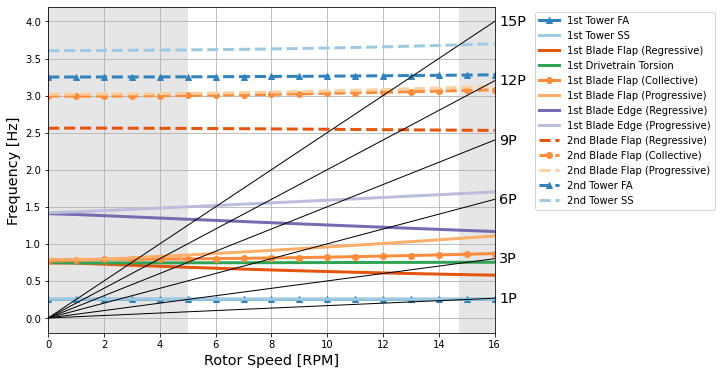

In [9]:
fig,ax = plt.subplots(figsize=(8,6))

# static natural frequencies (from WISDEM)
# ax.plot(0,design_tower_ss_freqs[0],'k>',markersize=14)
# ax.plot(0,design_tower_fa_freqs[0],'k>',markersize=14)
# ax.plot(0,design_flap_freqs[0],'k>',markersize=14)
# ax.plot(0,design_edge_freqs[0],'k>',markersize=14)
# ax.plot(0,design_flap_freqs[1],'k>',markersize=14)
# ax.plot(0,design_tower_ss_freqs[1],'k>',markersize=14)
# ax.plot(0,design_tower_fa_freqs[1],'k>',markersize=14)

#df.plot(ax=ax,marker='o') # uniform marker style, marker cycle ignored
#ax.get_legend().remove()

# plot modes
for (i,mode),(name,style) in zip(df.iteritems(),
                                 modes_styles.items()):
    ax.plot(mode.index, mode, lw=3, label=name, **style)
    
# fan plot
for n in [1,3,6,9,12,15]:
    ax.plot(rotor_speeds, n*rotor_speeds_Hz, 'k-', lw=1)
    ax.text(1.01*rotor_speeds[-1], n*rotor_speeds_Hz[-1], f'{n}P',
            fontsize='x-large', verticalalignment='center')
# indicate operational range
ax.axvspan(rotor_speeds[0], op.index.min(), color='0.9')
ax.axvspan(op.index.max(), rotor_speeds[-1], color='0.9')

# other formatting
ax.set_xlim((rotor_speeds[0],rotor_speeds[-1]))
ax.grid()
ax.legend(loc='upper left',bbox_to_anchor=(1.08,1))
ax.set_xlabel('Rotor Speed [RPM]',fontsize='x-large')
ax.set_ylabel('Frequency [Hz]',fontsize='x-large')

fig.savefig(f'{prefix}_Campbell_diagram.png',bbox_inches='tight')